#### Imports

In [2]:
import numpy as np
from PIL import ImageGrab #grabbing image
from PIL import Image
import cv2 #opencv
import io
import time
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (30, 30)
import seaborn as sns
import pandas as pd
import numpy as np
from random import randint
import os
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
#keras imports
%matplotlib inline 
from keras.models import model_from_json
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD , Adam
from keras.callbacks import TensorBoard
from collections import deque
import random
import pickle
import json

Using TensorFlow backend.


In [3]:
#variaveis path
game_url = "game/dino.html"
chrome_driver_path = "chromedriver.exe"
loss_file_path = "objects/loss_df.csv"
actions_file_path = "objects/actions_df.csv"
scores_file_path = "objects/scores_df.csv"

In [4]:
'''
* Game class: Selenium interfacing between the python and browser
* __init__():  Launch the broswer window using the attributes in chrome_options
* get_crashed() : return true if the agent as crashed on an obstacles. Gets javascript variable from game decribing the state
* get_playing(): true if game in progress, false is crashed or paused
* restart() : sends a signal to browser-javascript to restart the game
* press_up(): sends a single to press up get to the browser
* get_score(): gets current game score from javascript variables.
* pause(): pause the game
* resume(): resume a paused game if not crashed
* end(): close the browser and end the game
'''
class Game:
    def __init__(self,custom_config=True):
        chrome_options = Options()
        chrome_options.add_argument("disable-infobars")
        self._driver = webdriver.Chrome(executable_path = chrome_driver_path,chrome_options=chrome_options)
        self._driver.set_window_position(x=-10,y=0)
        self._driver.set_window_size(200, 300)
        self._driver.get(os.path.abspath(game_url))
        #modifying game before trainNetworkining
        if custom_config:
            self._driver.execute_script("Runner.config.ACCELERATION=0")
    def get_crashed(self):
        return self._driver.execute_script("return Runner.instance_.crashed")
    def get_playing(self):
        return self._driver.execute_script("return Runner.instance_.playing")
    def restart(self):
        self._driver.execute_script("Runner.instance_.restart()")
        
        time.sleep(0.25)# no actions are possible 
                        # for 0.25 sec after game starts, 
                        # skip learning at this time and make the model wait
    def press_up(self):
        self._driver.find_element_by_tag_name("body").send_keys(Keys.ARROW_UP)
    def get_score(self):
        score_array = self._driver.execute_script("return Runner.instance_.distanceMeter.digits")
        score = ''.join(score_array) # the javascript object is of type array with score in the formate[1,0,0] which is 100.
        return int(score)
    def pause(self):
        return self._driver.execute_script("return Runner.instance_.stop()")
    def resume(self):
        return self._driver.execute_script("return Runner.instance_.play()")
    def end(self):
        self._driver.close()

In [5]:
class DinoAgent:
    def __init__(self,game): #takes game as input for taking actions
        self._game = game; 
        self.jump(); #to start the game, we need to jump once
        time.sleep(.5) # no action can be performed for the first time when game starts
    def is_running(self):
        return self._game.get_playing()
    def is_crashed(self):
        return self._game.get_crashed()
    def jump(self):
        self._game.press_up()
    def duck(self):
        self._game.press_down()

In [6]:
class Game_sate:
    def __init__(self,agent,game):
        self._agent = agent
        self._game = game
        self._display = show_img() #display the processed image on screen using openCV, implemented using python coroutine 
        self._display.__next__() # initiliaze the display coroutine 
    def get_state(self,actions):
        actions_df.loc[len(actions_df)] = actions[1] # storing actions in a dataframe
        score = self._game.get_score() 
        reward = 0.1*score/10 # dynamic reward calculation
        is_over = False #game over
        if actions[1] == 1:
            self._agent.jump()
            reward = 0.1*score/11
        image = grab_screen() 
        self._display.send(image) #display the image on screen

        if self._agent.is_crashed():
            scores_df.loc[len(loss_df)] = score # log the score when game is over
            self._game.restart()
            reward = -11/score
            is_over = True
        return image, reward, is_over #return the Experience tuple

In [7]:
def save_obj(obj, name ):
    with open('objects/'+ name + '.pkl', 'wb') as f: #dump files into objects folder
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('objects/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
def grab_screen(_driver = None):
    screen =  np.array(ImageGrab.grab(bbox=(40,180,440,400))) #bbox = region of interset on the entire screen
    image = process_img(screen)#processing image as required
    return image

def process_img(image):
    #game is already in grey scale canvas, canny to get only edges and reduce unwanted objects(clouds)
    image = cv2.resize(image, (0,0), fx = 0.15, fy = 0.10) # resale image dimensions
    image = image[2:38,10:50] #img[y:y+h, x:x+w] #crop out the dino agent from the frame
    image = cv2.Canny(image, threshold1 = 100, threshold2 = 200) #apply the canny edge detection
    return  image
def show_img(graphs = False):
    """
    Show images in new window
    """
    while True:
        screen = (yield)
        window_title = "logs" if graphs else "game_play"
        cv2.namedWindow(window_title, cv2.WINDOW_NORMAL)        
        imS = cv2.resize(screen, (800, 400)) 
        cv2.imshow(window_title, screen)
        if (cv2.waitKey(1) & 0xFF == ord('q')):
            cv2.destroyAllWindows()
            break

In [8]:
#Intialize log structures from file if exists else create new
loss_df = pd.read_csv(loss_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns =['loss'])
scores_df = pd.read_csv(scores_file_path) if os.path.isfile(loss_file_path) else pd.DataFrame(columns = ['scores'])
actions_df = pd.read_csv(actions_file_path) if os.path.isfile(actions_file_path) else pd.DataFrame(columns = ['actions'])

In [9]:
# training variables saved as checkpoints to filesystem to resume training from the same step
def init_cache():
    """initial variable caching, done only once"""
    save_obj(INITIAL_EPSILON,"epsilon")
    t = 0
    save_obj(t,"time")
    D = deque()
    save_obj(D,"D")

In [10]:
#game parameters
ACTIONS = 2 # possible actions: jump, do nothing
GAMMA = 0.99 # decay rate of past observations original 0.99
OBSERVATION = 50000. # timesteps to observe before training
EXPLORE = 100000  # frames over which to anneal epsilon
FINAL_EPSILON = 0.0001 # final value of epsilon
INITIAL_EPSILON = 0.1 # starting value of epsilon
REPLAY_MEMORY = 50000 # number of previous transitions to remember
BATCH = 32 # size of minibatch
FRAME_PER_ACTION = 1
LEARNING_RATE = 1e-4
img_rows , img_cols = 40,20
img_channels = 4 #We stack 4 frames

In [11]:
def buildmodel():
    print("Now we build the model")
    model = Sequential()
    model.add(Conv2D(32, (8, 8), strides=(4, 4), padding='same',input_shape=(img_cols,img_rows,img_channels)))  #20*40*4
    model.add(Activation('relu'))
    model.add(Conv2D(64, (4, 4), strides=(2, 2), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dense(ACTIONS))
    adam = Adam(lr=LEARNING_RATE)
    model.compile(loss='mse',optimizer=adam)
    print("We finish building the model")
    return model

In [12]:
buildmodel().summary()

Now we build the model
We finish building the model
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 5, 10, 32)         8224      
_________________________________________________________________
activation_1 (Activation)    (None, 5, 10, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 5, 64)          32832     
_________________________________________________________________
activation_2 (Activation)    (None, 3, 5, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 5, 64)          36928     
_________________________________________________________________
activation_3 (Activation)    (None, 3, 5, 64)          0         
_________________________________________________________________
fl

In [13]:
''' 
main training module
Parameters:
* model => Keras Model to be trained
* game_state => Game State module with access to game environment and dino
* observe => flag to indicate wherther the model is to be trained(weight updates), else just play
'''
def trainNetwork(model,game_state,observe=False):
    last_time = time.time()
    # store the previous observations in replay memory
    D = load_obj("D") #load from file system
    # get the first state by doing nothing
    do_nothing = np.zeros(ACTIONS)
    do_nothing[0] =1 #0 => do nothing,
                     #1=> jump
    
    x_t, r_0, terminal = game_state.get_state(do_nothing) # get next step after performing the action
    

    s_t = np.stack((x_t, x_t, x_t, x_t), axis=2) # stack 4 images to create placeholder input
    

    
    s_t = s_t.reshape(1, s_t.shape[0], s_t.shape[1], s_t.shape[2])  #1*20*40*4
    
    initial_state = s_t 

    if observe :
        OBSERVE = 999999999    #We keep observe, never train
        epsilon = FINAL_EPSILON
        print ("Now we load weight")
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)
        print ("Weight load successfully")    
    else:                       #We go to training mode
        OBSERVE = OBSERVATION
        epsilon = load_obj("epsilon") 
        model.load_weights("model_final.h5")
        adam = Adam(lr=LEARNING_RATE)
        model.compile(loss='mse',optimizer=adam)

    t = load_obj("time") # resume from the previous time step stored in file system
    while (True): #endless running
        
        loss = 0
        Q_sa = 0
        action_index = 0
        r_t = 0 #reward at 4
        a_t = np.zeros([ACTIONS]) # action at t
        
        #choose an action epsilon greedy
        if t % FRAME_PER_ACTION == 0: #parameter to skip frames for actions
            if  random.random() <= epsilon: #randomly explore an action
                print("----------Random Action----------")
                action_index = random.randrange(ACTIONS)
                a_t[0] = 1
            else: # predict the output
                q = model.predict(s_t)       #input a stack of 4 images, get the prediction
                max_Q = np.argmax(q)         # chosing index with maximum q value
                action_index = max_Q 
                a_t[action_index] = 1        # o=> do nothing, 1=> jump
                
        #We reduced the epsilon (exploration parameter) gradually
        if epsilon > FINAL_EPSILON and t > OBSERVE:
            epsilon -= (INITIAL_EPSILON - FINAL_EPSILON) / EXPLORE 

        #run the selected action and observed next state and reward
        x_t1, r_t, terminal = game_state.get_state(a_t)
        print('loop took {} seconds'.format(time.time()-last_time)) # helpful for measuring frame rate
        last_time = time.time()
        x_t1 = x_t1.reshape(1, x_t1.shape[0], x_t1.shape[1], 1) #1x20x40x1
        s_t1 = np.append(x_t1, s_t[:, :, :, :3], axis=3) # append the new image to input stack and remove the first one
        
        
        # store the transition in D
        D.append((s_t, action_index, r_t, s_t1, terminal))
        if len(D) > REPLAY_MEMORY:
            D.popleft()

        #only train if done observing
        if t > OBSERVE: 
            
            #sample a minibatch to train on
            minibatch = random.sample(D, BATCH)
            inputs = np.zeros((BATCH, s_t.shape[1], s_t.shape[2], s_t.shape[3]))   #32, 20, 40, 4
            targets = np.zeros((inputs.shape[0], ACTIONS))                         #32, 2

            #Now we do the experience replay
            for i in range(0, len(minibatch)):
                state_t = minibatch[i][0]    # 4D stack of images
                action_t = minibatch[i][1]   #This is action index
                reward_t = minibatch[i][2]   #reward at state_t due to action_t
                state_t1 = minibatch[i][3]   #next state
                terminal = minibatch[i][4]   #wheather the agent died or survided due the action
                

                inputs[i:i + 1] = state_t    

                targets[i] = model.predict(state_t)  # predicted q values
                Q_sa = model.predict(state_t1)      #predict q values for next step
                
                if terminal:
                    targets[i, action_t] = reward_t # if terminated, only equals reward
                else:
                    targets[i, action_t] = reward_t + GAMMA * np.max(Q_sa)

            loss += model.train_on_batch(inputs, targets)
            loss_df.loc[len(loss_df)] = loss
        else:
            # artificial time delay as training done with this delay
            time.sleep(0.12)
        s_t = initial_state if terminal else s_t1 #reset game to initial frame if terminate
        t = t + 1
        
        # save progress every 1000 iterations
        if t % 1000 == 0:
            print("Now we save model")
            
            model.save_weights("model_final.h5", overwrite=True)
            save_obj(D,"D") #saving episodes
            save_obj(t,"time") #caching time steps
            save_obj(epsilon,"epsilon") #cache epsilon to avoid repeated randomness in actions
            loss_df.to_csv("./objects/loss_df.csv",index=False)
            scores_df.to_csv("./objects/scores_df.csv",index=False)
            actions_df.to_csv("./objects/actions_df.csv",index=False)
            with open("model.json", "w") as outfile:
                json.dump(model.to_json(), outfile)

        # print info
        state = ""
        if t <= OBSERVE:
            state = "observe"
        elif t > OBSERVE and t <= OBSERVE + EXPLORE:
            state = "explore"
        else:
            state = "train"

        print("TIMESTEP", t, "/ STATE", state,             "/ EPSILON", epsilon, "/ ACTION", action_index, "/ REWARD", r_t,             "/ Q_MAX " , np.max(Q_sa), "/ Loss ", loss)

    print("Episode finished!")
    print("************************")


In [14]:
def playGame(observe=False):
    game = Game()
    dino = DinoAgent(game)
    game_state = Game_sate(dino,game)
    model = buildmodel()
    try:
        trainNetwork(model,game_state,observe=observe)
    except StopIteration:
        game.end()

In [15]:
playGame(observe=False);

C:\Users\Felipe Lelis\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: use options instead of chrome_options


Now we build the model
We finish building the model


UnpicklingError: invalid load key, 'v'.

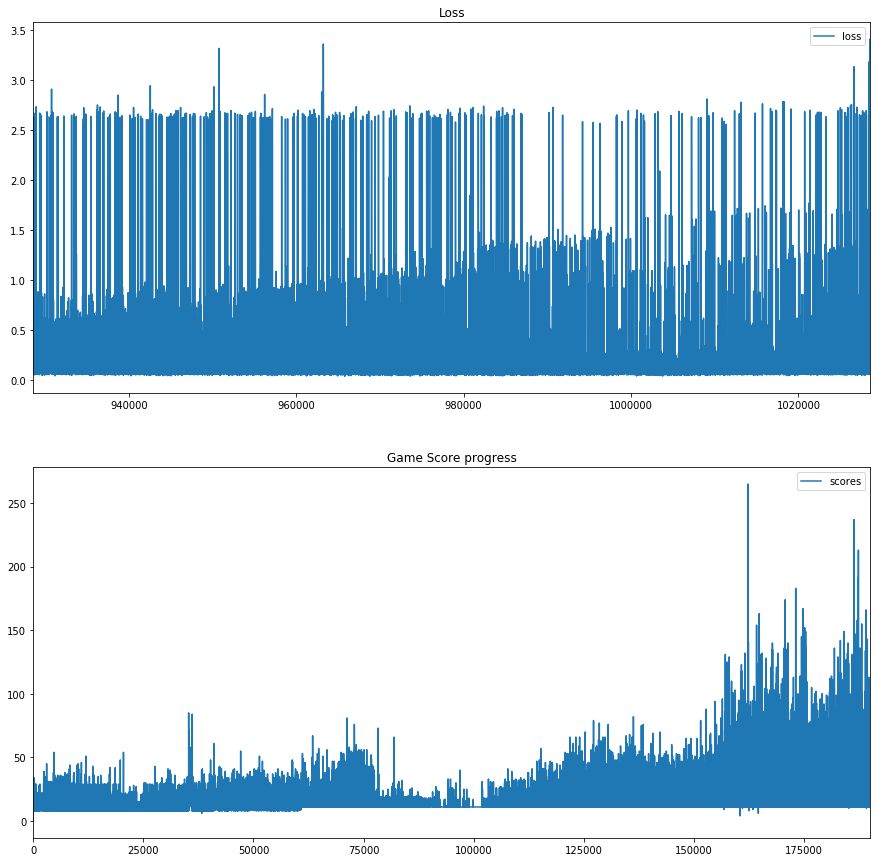

In [15]:
def show_plots():
    fig, axs = plt.subplots(ncols=1,nrows =2,figsize=(15,15))
    axs[0].set_title('Loss')
    axs[1].set_title('Game Score progress')
    loss_df = pd.read_csv("./objects/loss_df.csv").clip(0,50).tail(100000)
    scores_df = pd.read_csv("./objects/scores_df.csv").head(190000)
    
    actions_df = pd.read_csv("./objects/actions_df.csv").tail(100000)
    loss_df['loss'] = loss_df['loss'].astype('float') 
    loss_df.plot(use_index=True,ax=axs[0])
    scores_df.plot(ax=axs[1])
#     sns.distplot(actions_df,ax=axs[2])
    imgg = fig.canvas.draw()
show_plots()

In [17]:
#training_data_final_working.npy file contains the the keystrokes and gameframes recording for a score of 500
supervised_frames = np.load("training_data_final_working.npy")
frame = supervised_frames[0][0]
action_index = supervised_frames[0][1]
#plotting a sample frame from human recorded gameplay
plt.imshow(frame)
print('Action taken at this frame : Action index = {} i.e. jump'.format(str(action_index)))

FileNotFoundError: [Errno 2] No such file or directory: 'training_data_final_working.npy'

In [18]:
supervised_actions = []

for frame in supervised_frames:
    supervised_actions.append(frame[1])

NameError: name 'supervised_frames' is not defined

C:\Users\Felipe Lelis\Anaconda3\lib\site-packages\seaborn\distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
C:\Users\Felipe Lelis\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Felipe Lelis\Anaconda3\lib\site-packages\numpy\lib\histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


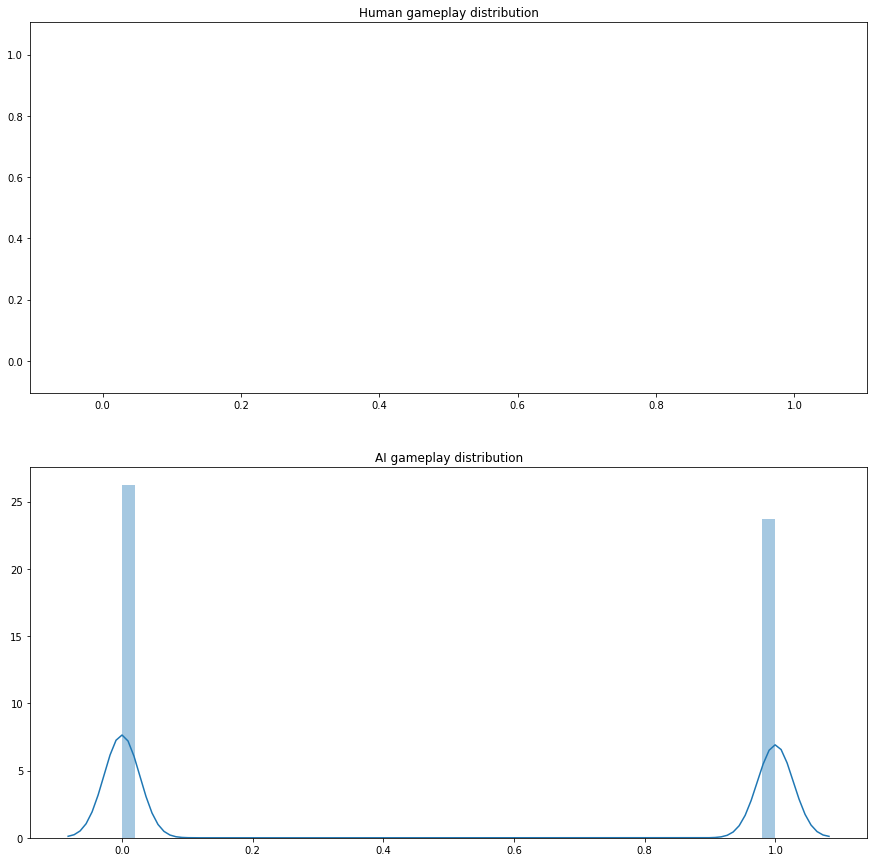

In [19]:
fig, axs = plt.subplots(ncols=1,nrows =2,figsize=(15,15))
sns.distplot(supervised_actions,ax=axs[0])
axs[1].set_title('AI gameplay distribution')
axs[0].set_title('Human gameplay distribution')
actions_df = pd.read_csv("./objects/actions_df.csv")
sns.distplot(actions_df,ax=axs[1])